In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats

plt.style.use("tableau-colorblind10")

F_SHOW = False


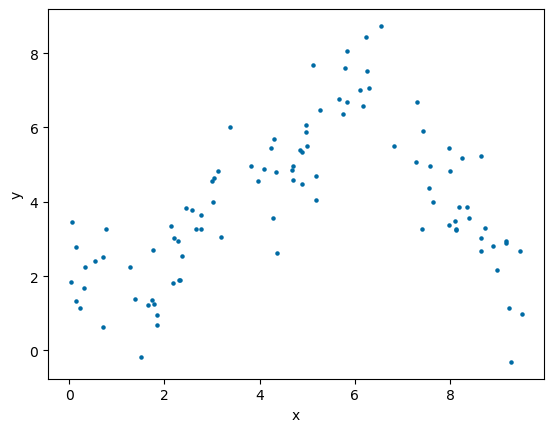

In [2]:
N = 100
rng = np.random.default_rng(123)

x = rng.uniform(0, 10, size=N)


def f(x):
    return 1 + np.cos(x * 2) + x * np.sin(x / 3)


eps = rng.normal(loc=0, scale=1.0, size=N)
y = f(x) + eps

x_line = np.linspace(x.min(), x.max())
if F_SHOW:
    plt.plot(x_line, f(x_line), c="k", ls="--", label="f(x)")
    plt.legend()
plt.scatter(x, y, s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


In [3]:
df = pd.DataFrame.from_dict({"y": y, "x": x})
df.to_csv("toy_data.csv", index=False)


# OLS

In [4]:
ols = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     11.45
Date:                Mon, 24 Apr 2023   Prob (F-statistic):            0.00103
Time:                        17:34:16   Log-Likelihood:                -204.47
No. Observations:                 100   AIC:                             412.9
Df Residuals:                      98   BIC:                             418.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8534      0.372      7.663      0.000       2.114       3.592
x1             0.2264      0.067      3.385      0.001       0.094       0.359
==============================================================================
Omnibus:                        0.062   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.969   Jarque-Bera (JB):                0.113
Skew:                           0.057   Prob(JB):                        0.945
Kurtosis:                       2.881   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

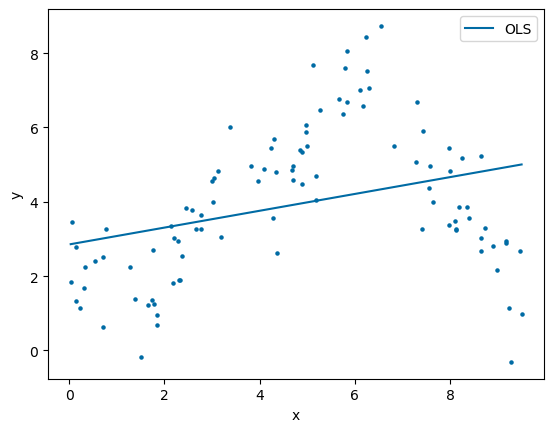

In [5]:
x_line = np.linspace(x.min(), x.max())

plt.scatter(x, y, s=5)
if F_SHOW:
    plt.plot(x_line, f(x_line), c="k", ls="--", label="f(x)")
plt.plot(x_line, ols.predict(sm.add_constant(x_line)), label="OLS")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


# 多項式基底関数

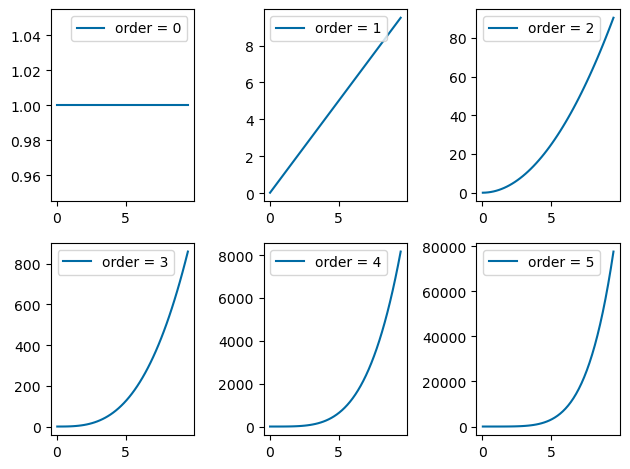

In [6]:
def PolyBasis(x, p=5):
    pwr = np.arange(p + 1)
    return x[:, None] ** pwr[None]


x_line = np.linspace(x.min(), x.max())
phi_line = PolyBasis(x_line, p=5)
for p in range(phi_line.shape[1]):
    plt.subplot(2, 3, p + 1)
    plt.plot(x_line, phi_line[:, p], label="order = {}".format(p))
    plt.legend()
plt.tight_layout()
plt.show()


In [7]:
phi = PolyBasis(x, p=5)
ols_poly = sm.OLS(endog=y, exog=phi).fit()
ols_poly.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     53.15
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           6.53e-26
Time:                        17:34:17   Log-Likelihood:                -142.89
No. Observations:                 100   AIC:                             297.8
Df Residuals:                      94   BIC:                             313.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2786      0.503      4.530      0.000       1.280       3.277
x1            -1.0867      1.243     -0.874      0.384      -3.555       1.382
x2             0.5279      0.868      0.608      0.545      -1.196       2.252
x3             0.0256      0.236      0.109      0.914      -0.443       0.494
x4            -0.0163      0.027     -0.597      0.552      -0.070       0.038
x5             0.0009      0.001      0.829      0.409      -0.001       0.003
==============================================================================
Omnibus:                        0.139   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.933   Jarque-Bera (JB):                0.228
Skew:                          -0.085   Prob(JB):                        0.892
Kurtosis:                       2.839   Cond. No.                     3.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

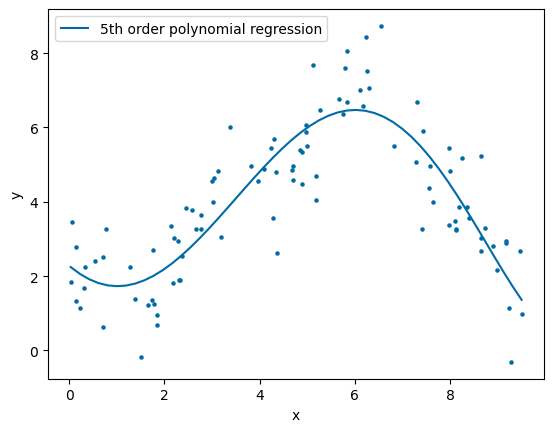

In [8]:
x_line = np.linspace(x.min(), x.max())
p = phi.shape[1] - 1
phi_line = PolyBasis(x_line, p=p)

plt.scatter(x, y, s=5)
if F_SHOW:
    plt.plot(x_line, f(x_line), c="k", ls="--", label="f(x)")
plt.plot(
    x_line,
    ols_poly.predict(phi_line),
    label="{}th order polynomial regression".format(p),
)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


# 階段型(Step)基底関数

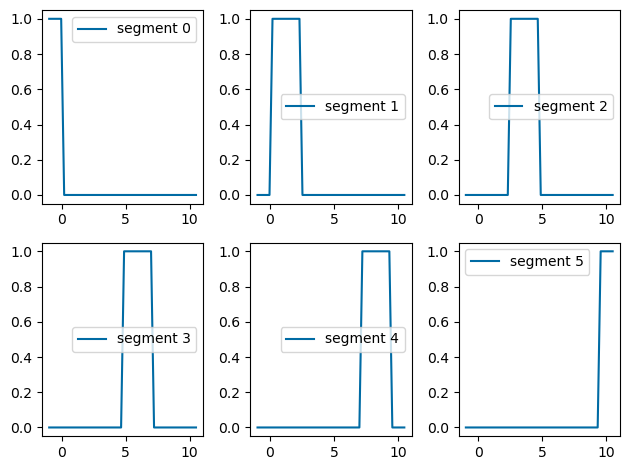

In [9]:
def StepBasis(x, n=10, xmin=x.min(), xmax=x.max(), with_end=True):
    knots = np.linspace(xmin, xmax, num=n + 1, endpoint=True)
    mask1 = x[:, None] < np.append(knots, np.inf)[None]
    mask2 = np.append(-np.inf, knots)[None] <= x[:, None]
    phi = (mask1 * mask2).astype(float)

    if with_end:
        return phi
    else:
        return phi[:, 1:-1]


x_line = np.linspace(x.min() - 1, x.max() + 1)
phi_line = StepBasis(x_line, n=4)
for p in range(phi_line.shape[1]):
    plt.subplot(2, 3, p + 1)
    plt.plot(x_line, phi_line[:, p], label="segment {}".format(p))
    plt.legend()
plt.tight_layout()
plt.show()


In [10]:
phi = StepBasis(x, n=10)
ols_seg = sm.OLS(endog=y, exog=phi).fit()
ols_seg.summary()


/home/hayato/.pyenv/versions/miniconda3-latest/envs/main/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     34.06
Date:                Mon, 24 Apr 2023   Prob (F-statistic):           3.08e-26
Time:                        17:34:19   Log-Likelihood:                -131.28
No. Observations:                 100   AIC:                             284.6
Df Residuals:                      89   BIC:                             313.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        nan           0           0
x1             2.1176      0.287      7.368      0.000       1.546       2.689
x2             1.2935      0.318      4.071      0.000       0.662       1.925
x3             2.9385      0.275     10.679      0.000       2.392       3.485
x4             4.5800      0.360     12.712      0.000       3.864       5.296
x5             4.5963      0.301     15.248      0.000       3.997       5.195
x6             5.6655      0.287     19.712      0.000       5.094       6.237
x7             7.4014      0.301     24.554      0.000       6.802       8.000
x8             5.1100      0.360     14.183      0.000       4.394       5.826
x9             4.0075      0.287     13.943      0.000       3.436       4.579
x10            2.5983      0.287      9.041      0.000       2.027       3.169
x11            0.9831      0.953      1.031      0.305      -0.911       2.877
==============================================================================
Omnibus:                        2.657   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.234
Skew:                          -0.163   Prob(JB):                        0.327
Kurtosis:                       3.655   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

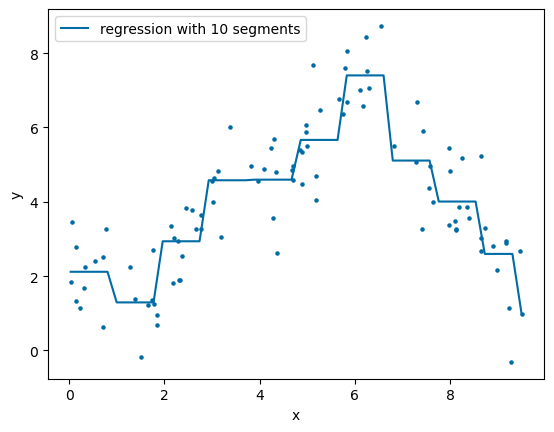

In [11]:
x_line = np.linspace(x.min(), x.max())
n = phi.shape[1] - 2
phi_line = StepBasis(x_line, n=n)

plt.scatter(x, y, s=5)
if F_SHOW:
    plt.plot(x_line, f(x_line), c="k", ls="--", label="f(x)")
plt.plot(
    x_line,
    ols_seg.predict(phi_line),
    label="regression with {} segments".format(n),
)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
